# **Problema Airbnb**

O problema consiste em identificar, através dos dados fornecidos, oportunidades de aumento da rentabilidade e da taxa de ocupação dos imóveis disponíveis para aluguel.

## Estrutura do notebook
1. Preparação dos dados
2. Análise Exploratória
3. Modelagem
4. Interpretabilidade
5. Proposta de pipeline de produtização

In [49]:
# Bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

# Configuração do Pandas
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None

## Preparação dos Dados

In [50]:
# Importando a base de dados
df_airbnb = pd.read_excel('../teste_pratico_cinnecta/Teste Prático_ Cientista de Dados_airbnb_21.03.2023 (1).xlsx')

# Adequando variáveis para formato bool
df_airbnb['host_is_superhost'] = df_airbnb['host_is_superhost'].map({'t': True, 'f': False})
df_airbnb['instant_bookable'] = df_airbnb['instant_bookable'].map({'t': True, 'f': False})

# Função para converter o formato 3776931.0 em decimal (-37.76931)
def convert_to_decimal(value):
    return value / 100000

# Adequando o formato dos dados de Latitude e Longitude para permitir plotagens geoespaciais
df_airbnb['latitude'] = df_airbnb['latitude'].apply(convert_to_decimal)
df_airbnb['longitude'] = df_airbnb['longitude'].apply(convert_to_decimal)

df_airbnb

,host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,bedrooms_na,bathrooms_na,beds_na,review_scores_rating_na,review_scores_accuracy_na,review_scores_cleanliness_na,review_scores_checkin_na,review_scores_communication_na,review_scores_location_na,review_scores_value_na
0,True,moderate,True,1.0,Western Addition,37.76931,-122.43386,Apartment,Entire home/apt,3.0,1.0,1.0,2.0,Real Bed,1.0,180.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,False,strict_14_with_grace_period,False,2.0,Bernal Heights,37.74511,-122.42102,Apartment,Entire home/apt,5.0,1.0,2.0,3.0,Real Bed,30.0,111.0,98.0,10.0,10.0,10.0,10.0,10.0,9.0,235.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,False,strict_14_with_grace_period,False,10.0,Haight Ashbury,37.76669,-12.24525,Apartment,Private room,2.0,4.0,1.0,1.0,Real Bed,32.0,17.0,85.0,8.0,8.0,9.0,9.0,9.0,8.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,False,strict_14_with_grace_period,False,10.0,Haight Ashbury,37.76487,-122.45183,Apartment,Private room,2.0,4.0,1.0,1.0,Real Bed,32.0,8.0,93.0,9.0,9.0,10.0,10.0,9.0,9.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,False,strict_14_with_grace_period,False,2.0,Western Addition,37.77525,-122.43637,House,Entire home/apt,5.0,2022-05-01 00:00:00,2.0,2.0,Real Bed,7.0,27.0,97.0,10.0,10.0,10.0,10.0,10.0,9.0,785.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7141,False,flexible,True,18.0,Noe Valley,37.74884,-12.24283,House,Entire home/apt,3.0,1.0,1.0,2.0,Real Bed,30.0,0.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,163.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7142,True,flexible,True,10.0,Russian Hill,37.80645,-122.42109,Guest suite,Entire home/apt,2.0,1.0,0.0,1.0,Real Bed,1.0,0.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,160.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7143,True,flexible,True,10.0,Western Addition,37.78855,-12.24311,Apartment,Entire home/apt,4.0,1.0,1.0,1.0,Real Bed,2.0,0.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,249.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7144,False,flexible,True,87.0,Downtown/Civic Center,37.78645,-122.41458,Apartment,Entire home/apt,3.0,1.0,1.0,2.0,Real Bed,30.0,0.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,105.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [51]:
# Identificando os valores da coluna "bathrooms"
df_airbnb.bathrooms.value_counts()

1.0                    5145
2.0                    1005
2022-05-01 00:00:00     480
2022-05-02 00:00:00     173
3.0                     132
2022-05-03 00:00:00      54
0.0                      39
4.0                      32
5.0                      26
0.5                      17
8.0                      15
10.0                     12
2022-05-04 00:00:00       8
6.0                       6
2022-05-05 00:00:00       1
14.0                      1
Name: bathrooms, dtype: int64

In [52]:
# Essa coluna deveria trazer apenas valores numéricos, para corrigir essa questão, criamos uma função que converte os valores
def convert_to_integer_or_nan(value):
    try:
        return int(float(value)) # Tenta converter em int (Variável discreta, pois representa quantidade de banheiros)
    except (ValueError, TypeError):
        return None if '-' in str(value) else int(float(value)) # Se contém um traço, é uma data
# A abordagem de remover as datas se da pois não faz sentido termos dados de data em uma coluna que representa quantidade

df_airbnb['bathrooms'] = df_airbnb['bathrooms'].apply(convert_to_integer_or_nan)
df_airbnb.bathrooms.value_counts()

1.0     5145
2.0     1005
3.0      132
0.0       56
4.0       32
5.0       26
8.0       15
10.0      12
6.0        6
14.0       1
Name: bathrooms, dtype: int64

In [53]:
df_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7146 entries, 0 to 7145
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_is_superhost               7146 non-null   bool   
 1   cancellation_policy             7146 non-null   object 
 2   instant_bookable                7146 non-null   bool   
 3   host_total_listings_count       7146 non-null   float64
 4   neighbourhood_cleansed          7146 non-null   object 
 5   latitude                        7146 non-null   float64
 6   longitude                       7146 non-null   float64
 7   property_type                   7146 non-null   object 
 8   room_type                       7146 non-null   object 
 9   accommodates                    7146 non-null   float64
 10  bathrooms                       6430 non-null   float64
 11  bedrooms                        7146 non-null   float64
 12  beds                            71

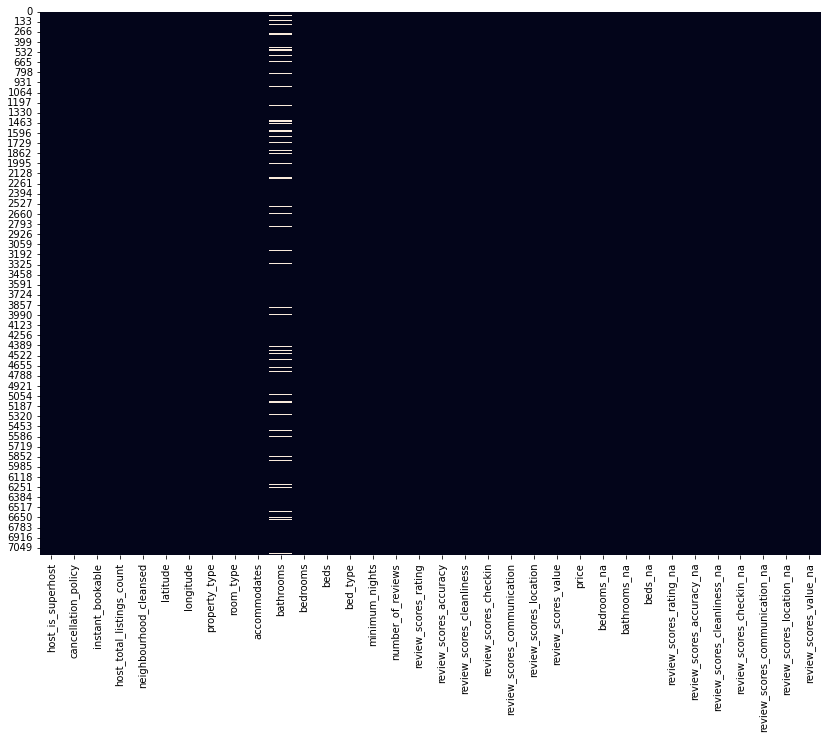

In [54]:
# Identificando campos nulos
plt.figure(figsize=[14,10])
sns.heatmap(df_airbnb.isna(), cbar=False, annot=False)
plt.show()
# O gráfico criado mostrará marcações indicando onde os dados estão nulos e quais as linhas e colunas

In [55]:
# Existem dados nulos apenas na coluna que representa a quantidade de banheiros, esses dados estavam em formato de data
# Testando a proporção da base que restaria caso fosse utilizado o dropna
qtd_dropna = df_airbnb.dropna().shape[0]
qtd_real = df_airbnb.shape[0]
proporcao = (qtd_dropna/qtd_real)*100

print(f'Removendo os nulos restaria {proporcao}% da base')

Removendo os nulos restaria 89.98040862020711% da base


Como a quantidade de dados restantes é próxima de 90% da base original, a abordagem de limpar os dados nulos não resulta em perda significativa dos dados

In [56]:
df = df_airbnb.dropna() # Para as análises subsequentes vamos utilizar o DataFrame 'df'
df

,host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,bedrooms_na,bathrooms_na,beds_na,review_scores_rating_na,review_scores_accuracy_na,review_scores_cleanliness_na,review_scores_checkin_na,review_scores_communication_na,review_scores_location_na,review_scores_value_na
0,True,moderate,True,1.0,Western Addition,37.76931,-122.43386,Apartment,Entire home/apt,3.0,1.0,1.0,2.0,Real Bed,1.0,180.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,False,strict_14_with_grace_period,False,2.0,Bernal Heights,37.74511,-122.42102,Apartment,Entire home/apt,5.0,1.0,2.0,3.0,Real Bed,30.0,111.0,98.0,10.0,10.0,10.0,10.0,10.0,9.0,235.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,False,strict_14_with_grace_period,False,10.0,Haight Ashbury,37.76669,-12.24525,Apartment,Private room,2.0,4.0,1.0,1.0,Real Bed,32.0,17.0,85.0,8.0,8.0,9.0,9.0,9.0,8.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,False,strict_14_with_grace_period,False,10.0,Haight Ashbury,37.76487,-122.45183,Apartment,Private room,2.0,4.0,1.0,1.0,Real Bed,32.0,8.0,93.0,9.0,9.0,10.0,10.0,9.0,9.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,False,moderate,False,1.0,Western Addition,37.78471,-122.44555,Apartment,Entire home/apt,6.0,1.0,2.0,3.0,Real Bed,2.0,31.0,90.0,9.0,8.0,10.0,10.0,9.0,9.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7141,False,flexible,True,18.0,Noe Valley,37.74884,-12.24283,House,Entire home/apt,3.0,1.0,1.0,2.0,Real Bed,30.0,0.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,163.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7142,True,flexible,True,10.0,Russian Hill,37.80645,-122.42109,Guest suite,Entire home/apt,2.0,1.0,0.0,1.0,Real Bed,1.0,0.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,160.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7143,True,flexible,True,10.0,Western Addition,37.78855,-12.24311,Apartment,Entire home/apt,4.0,1.0,1.0,1.0,Real Bed,2.0,0.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,249.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7144,False,flexible,True,87.0,Downtown/Civic Center,37.78645,-122.41458,Apartment,Entire home/apt,3.0,1.0,1.0,2.0,Real Bed,30.0,0.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,105.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [57]:
# Buscando outras inconsistências
df.describe()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,bedrooms_na,bathrooms_na,beds_na,review_scores_rating_na,review_scores_accuracy_na,review_scores_cleanliness_na,review_scores_checkin_na,review_scores_communication_na,review_scores_location_na,review_scores_value_na
count,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000
mean,56.301089,34.275058,-111.461421,3.083515,1.259565,1.263297,1.687558,15.956610,44.388647,95.934370,9.816952,9.700622,9.893935,9.869362,9.713686,9.522084,199.598911,0.000156,0.003266,0.000622,0.204044,0.204666,0.204510,0.204821,0.204355,0.204821,0.204977
std,182.647036,10.379511,33.215579,1.809833,0.777442,0.878286,1.100015,21.919999,73.922830,6.472771,0.619026,0.710420,0.458864,0.535309,0.671614,0.765808,287.752716,0.012471,0.057059,0.024936,0.403032,0.403488,0.403375,0.403602,0.403261,0.403602,0.403716
min,0.000000,0.000377,-122.513060,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,37.742243,-122.440455,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,95.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,37.763275,-122.421895,2.000000,1.000000,1.000000,1.000000,4.000000,11.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,150.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,37.782550,-122.407620,4.000000,1.000000,2.000000,2.000000,30.000000,55.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,225.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1199.000000,37.810310,-0.001224,16.000000,14.000000,14.000000,14.000000,365.000000,677.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Analisando os valores médios das demais variáveis numéricas em comparação com os máximos e mínimos, não foram encontradas anomalias

## Análise Exploratória

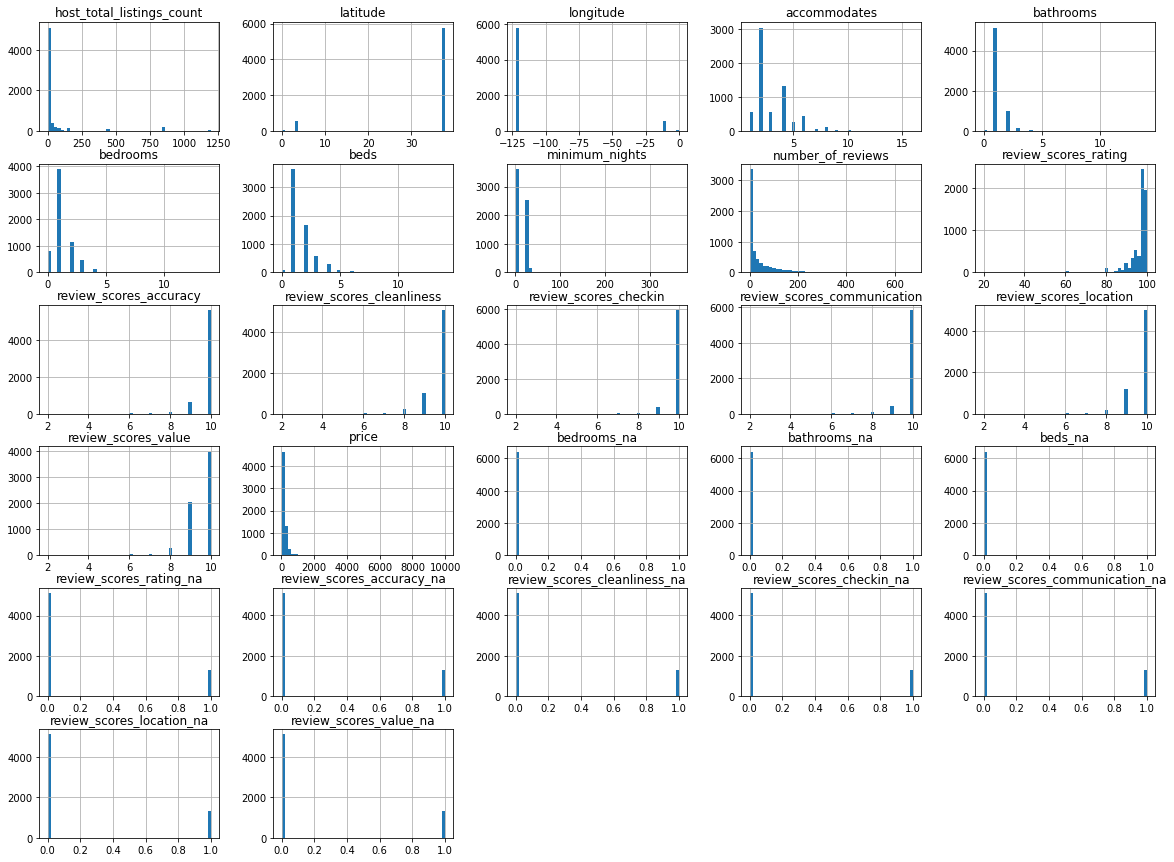

In [58]:
# Identificando a distribuição das variáveis numéricas
%matplotlib inline
df.hist(bins=50, figsize=(20,15))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


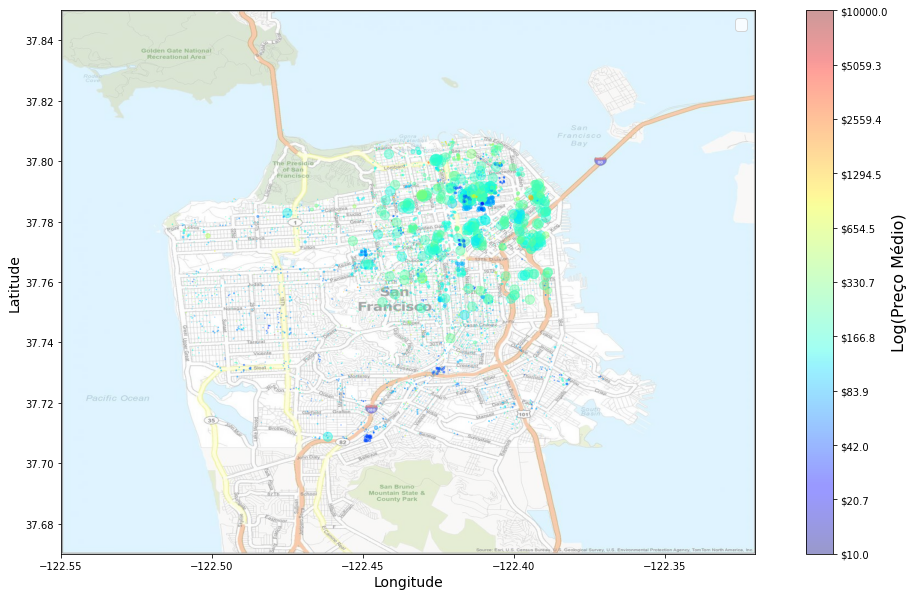

In [59]:
# Identificando se existe relação entre o valor do aluguel e a localização dos imóveis
# Carregar imagem de fundo
san_francisco_img = mpimg.imread('../teste_pratico_cinnecta/San-Francisco-Road-Map-1265x1265.jpg')

# Criar o plot
fig, ax = plt.subplots(figsize=(18, 10))

# Aplicar escala logarítmica à cor dos pontos
sc = ax.scatter(
    df['longitude'], df['latitude'],
    c=np.log1p(df['price']), cmap=plt.get_cmap('jet'),  # Aplicar log1p para evitar valores negativos
    s=df['host_total_listings_count']/10, alpha=.4
)

# Plot da imagem de fundo
ax.imshow(san_francisco_img, extent=[-122.55, -122.32, 37.67, 37.85], alpha=.5, cmap=plt.get_cmap('jet'))

# Configurar o colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Log(Preço Médio)', fontsize=16)

# Ajustar as etiquetas do colorbar
tick_values = np.linspace(np.log1p(df['price']).min(), np.log1p(df['price']).max(), 11)
cbar.set_ticks(tick_values)
cbar.set_ticklabels(['$%.1f'%(np.expm1(v)) for v in tick_values])  # Usar expm1 para reverter o log1p

# Configurações de rótulos e legenda
plt.ylabel('Latitude', fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.legend(fontsize=16)

# Exibir o gráfico
plt.show()

Com base no gráfico podemos retirar alguns insights:
1. De acordo com o tamanho da bolha que indica a quantidade de locações
    1. A maior incidência de locações esta em regiões próximas a San Francisco Bay
    2. Em segundo lugar vemos a região central da cidade com uma forte procura por imóveis
    3. Existe a busca por imóveis mais próximos ao Oceano Pacífico, entretanto, em menor quantidade
2. De acordo com a escala de cores adotada que indica o valor dos imóveis
    1. Os imóveis nas regiões de San Francisco Bay tende a ser mais caros
    2. Os imóveis próximos ao Oceano Pacífico são mais baratos, o que justificaria a existência de procura por esse local
    3. Os imóveis alugados próximos a Highway 280 também apresentaram preços mais baratos

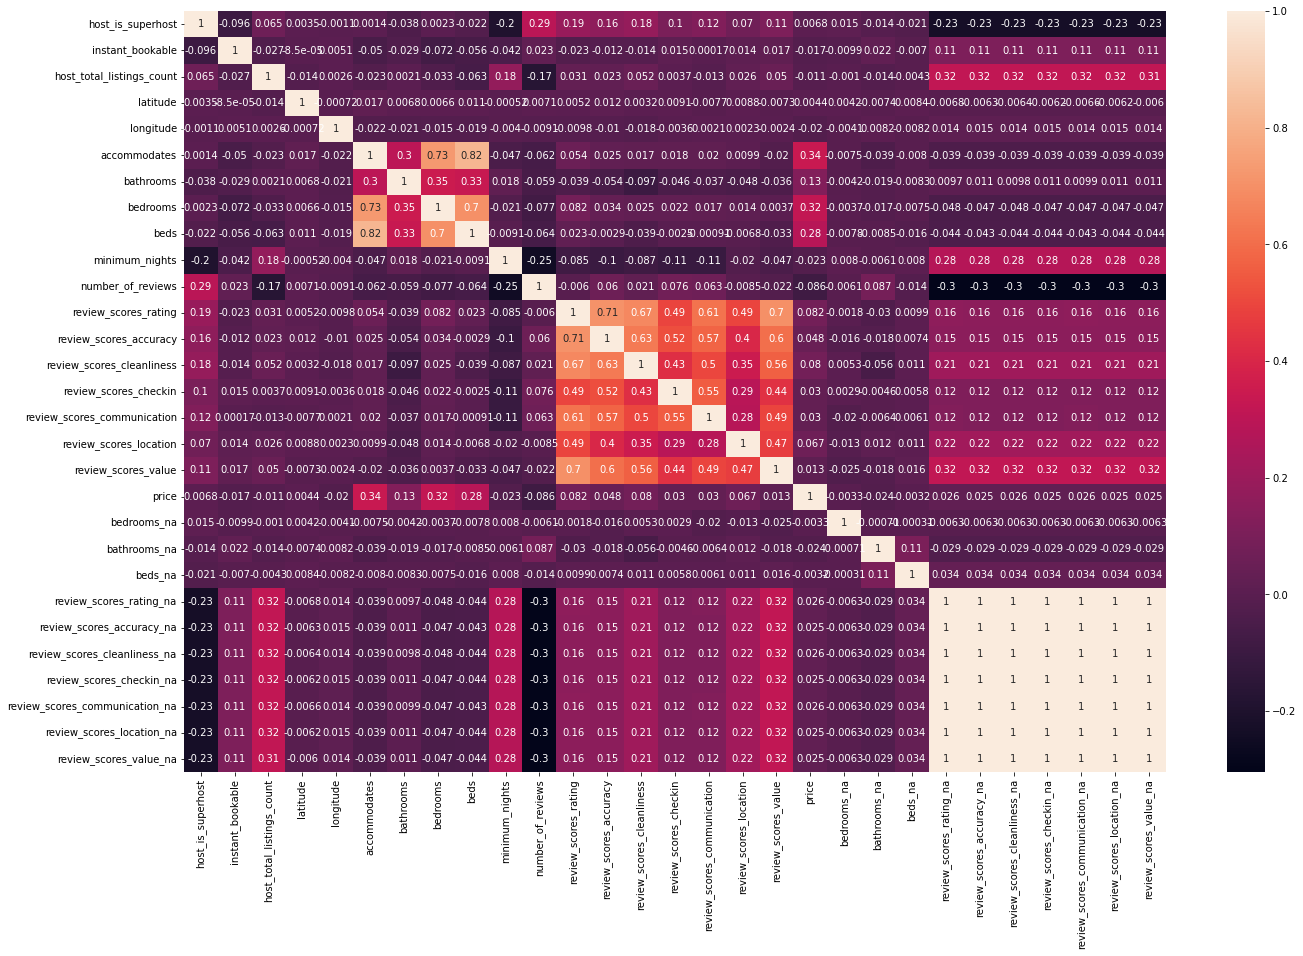

In [60]:
# Buscando correlações entre as variáveis numéricas
plt.figure(figsize=[22,14])
sns.heatmap(df.corr(), annot=True, cbar=True)
plt.show()

Com essas correlações identificamos que existe uma forte relação entre as avaliações, indicando que um cliente com boa experiência irá avaliar positivamente em todos os aspectos. As características do imóvem são bem correlacionadas, visto que imóveis maiores tendem a apresentar maior quantidade de quartos, camas e banheiros. Analisando a linha referente ao preço praticado, nota-se que as maiores correlações são aquelas referentes as características do imóvel.

## Modelagem
Com base nos insights obtidos nas análises exploratórias realizadas, podemos identificar como oportunidade verificar se os preços corretos são os mais indicados, um ajuste nos preços viabilizaria mais locações aumentando a rentabilidade e a taxa de ocupação. Para isso, foram considerados alguns critérios:
### Base para o modelo
Para a base de treino e teste do modelo, vamos considerar as locações com maior quantidade de agendamentos, entendendo que essas estão mais adequadas levando em consideração o volume de locações. Com base nos resultados observados na distribuição da coluna 'host_total_listings_count', vamos considerar para isso os imóveis com mais de 24 agendamentos, o que representaria em média 2 agendamentos por mês em um horizonte de um ano.
### Base de Validação
As locações que apresentam baixas quantidades de agendamentos, pela premissa da oportunidade, queremos verificar se essa quantidade baixa de agendamento está atrelada a prática de preços não adequados.
### Modelo escolhido
Para esse problema vamos utilizar em sua resolução um modelo de Random Forest, a escolha desse modelo se dá pela facilidade na busca por padrões não lineares e nas relações em diferentes cenários, tarefa pela qual modelos baseados em árvore tendem a ser mais promissores
### Target
Coluna da base referente aos preços de locação

#### Funções Úteis

In [61]:
def get_model(X, y, nsplit=3, min_features=10, njobs=-1):
    '''
    Retorna o RFE + CV 
    '''
    rfc = RandomForestRegressor(random_state=13)
    kfold = StratifiedKFold(n_splits=nsplit, shuffle=True) 
    cv = kfold.split(X, y)
    return RFECV(estimator=rfc, step=nsplit, min_features_to_select=min_features, cv=cv, n_jobs=njobs)

In [62]:
def get_features_info(rfecv, X, df, style=None):
    '''
    Retorna a análise das features selecionadas pelo RFECV + dataframe com essas features
    '''
    print('Número ótimo de variáveis selecionadas pelo RFE: {}'.format(rfecv.n_features_))
    
    if not style:
        style = {'font-family': 'manrope', 
                 'color-header': 'white',
                 'background-header': '#000000',
                 'header-fsize': '16px',
                 'background-even': '#7a7423',
                 'background-odd': '#a7e82b',
                 'rows-fsize' : '14px',
                 'figsize': (12,12),
                 'cmap': 'Greens',
                 'color': '#a7e82b'}
        
    # Visualizando as importancia das variáveis selecionadas
    X2 = X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1)
    dset = pd.DataFrame()
    dset['attr'] = X2.columns
    dset['importance'] = rfecv.estimator_.feature_importances_
    dset = dset.sort_values(by='importance', ascending=True)

    fig, axs = plt.subplots(2,1, figsize=style['figsize'], gridspec_kw={'height_ratios': [1, 3]})
    fig.suptitle('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold')
    axs[0].plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"], 
                color=style['color'], linewidth=3)
    axs[0].set_xlabel('Number of features selected', fontsize=14, labelpad=20)
    axs[0].set_ylabel('% Correct Classification', fontsize=14, labelpad=20)
    axs[1].barh(y=dset['attr'], width=dset['importance'], color=style['color'])
    axs[1].set_xlabel('Importancia', fontsize=14, labelpad=20)
    
    # Tabela com as variáveis e seu percentual de importancia
    df_import = pd.DataFrame(zip(dset.attr, [f'{x*100:.2f}%' for x in dset.importance.sort_values(ascending=True)]), columns=['Variável', 'Importancia'])
    print(df_import)

    # Variáveis selecionadas pelo RFE/RF
    cols_rfe = dset.attr
    # Dataframe com as features selecionadas 
    return df_import, df[cols_rfe.tolist()]

In [63]:
def get_cols(df, target='price', cols2exc=[]):
    '''
    Separa as features para normalização, enconding e target
    '''
    # features que passarão pelo enconding - objetos 
    cols2enc = [target] + [x for x in df.select_dtypes(include=['object']).columns if x not in cols2exc and x not in [target]]
    # features que serão normalizadas
    cols2norm = [x for x in df.select_dtypes(include=['int64', 'float64']).columns if x not in cols2exc and x not in cols2enc] 
        
    return cols2enc, cols2norm 

def normalizing(df, target='price', cols2exc=[]):
    '''
    Aplica o enconding e normalização aos dados
    '''   
    # separate cols
    cols2enc, cols2norm = get_cols(df, target, cols2exc)
    #print(cols2enc, cols2norm)
    df_norm = pd.DataFrame()
    
    # encoding 
    enc_mapping = list()
    encoder = LabelEncoder()
    for col in cols2enc:
        encoded = encoder.fit_transform(df[col])#.astype(str))
        df_norm[col] = encoded
        mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
        enc_mapping.append([col, mapping])
        
    # normalizing
    scaler = MinMaxScaler()
    for col in cols2norm:
        encoded = scaler.fit_transform(df[col].astype(float).values.reshape(-1, 1))
        df_norm[col] = encoded
        
    return df_norm, enc_mapping

In [64]:
def eval_model_all_regressor(model, X, y, X_train, X_test, y_train, y_test):
    '''
    Retorna todas as principais métricas levando em consideração todos os dados
    '''

    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    y_pall = model.predict(X)
    
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred)
    mse_all = mean_squared_error(y, y_pall)
    print(f'Mean Squared Error for train: {mse_train:.2f}')
    print(f'Mean Squared Error for test: {mse_test:.2f}')
    print(f'Mean Squared Error for all: {mse_all:.2f} \n')
    
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_all = mean_absolute_error(y, y_pall)
    print(f'Mean Absolute Error for train: {mae_train:.2f}')
    print(f'Mean Absolute Error for test: {mae_test:.2f}')
    print(f'Mean Absolute Error for all: {mae_all:.2f} \n')
    
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_all = r2_score(y, y_pall)
    print(f'R^2 Score for train: {r2_train:.2f}')
    print(f'R^2 Score for test: {r2_test:.2f}')
    print(f'R^2 Score for all: {r2_all:.2f} \n')

#### Construindo o modelo

In [65]:
df_model = df[df.host_total_listings_count>=24]
df_validation = df[df.host_total_listings_count<24]

In [66]:
df_norm, enc_mapping = normalizing(df_model, target='price', cols2exc=[])

In [102]:
# Identificando o target
target = ['price']

# Inserindo o noise para o feature importance
df_norm['NOISE1'] = np.random.normal(0,1, df_norm.shape[0])
df_norm['NOISE2'] = np.random.rand(df_norm.shape[0])

# Separando as features
X = df_norm.drop(target, axis=1) # Features
y = df_norm[target[0]] # Target

# Estanciando o modelo para o RFE
rfecv = get_model(X, y, nsplit=3, min_features=5)

# Fit do modelo
%time rfecv.fit(X,y)

Wall time: 9.63 s


RFECV(cv=<generator object _BaseKFold.split at 0x00000189F0FFE820>,
      estimator=RandomForestRegressor(random_state=13),
      min_features_to_select=5, n_jobs=-1, step=3)

Número ótimo de variáveis selecionadas pelo RFE: 12
                     Variável Importancia
0                   bathrooms       2.11%
1                        beds       3.24%
2              minimum_nights       3.57%
3                   longitude       4.76%
4      neighbourhood_cleansed       5.13%
5         cancellation_policy       5.24%
6               property_type       5.33%
7                    bedrooms       6.76%
8                    latitude       9.89%
9                   room_type      10.01%
10               accommodates      13.79%
11  host_total_listings_count      30.17%


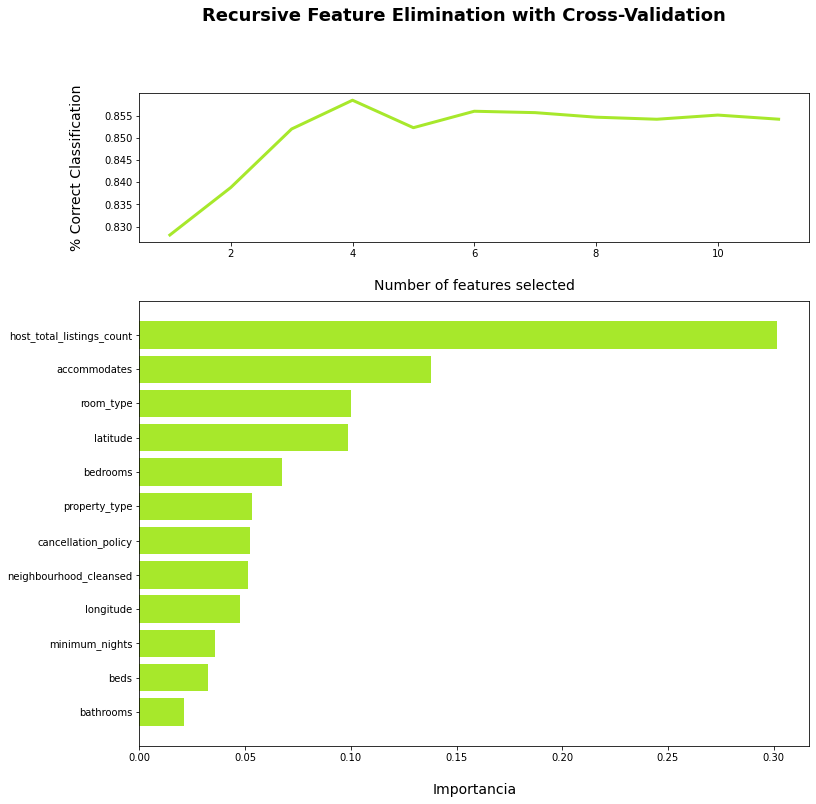

In [103]:
# Realizando o RFE
df_imp, df_rfe = get_features_info(rfecv, X, df_norm)

##### Explicando o RFE
Nesse processo realizamos o Recursive Feature Elimination, a ideia é identificar quais variáveis são mais pertinentes para a modelagem, o uso das variáveis aleatórias NOISE1 e NOISE2 é feito para identificar toda variável que apresenta menor importância do que uma totalmente aleatória, essas variáveis não são significativas para o modelo

In [104]:
list(df_imp.Variável)

['bathrooms',
 'beds',
 'minimum_nights',
 'longitude',
 'neighbourhood_cleansed',
 'cancellation_policy',
 'property_type',
 'bedrooms',
 'latitude',
 'room_type',
 'accommodates',
 'host_total_listings_count']

In [105]:
cols2exc = []

df_rfe = df_rfe.drop(cols2exc, axis=1)
df_rfe[target[0]] = y
df_rfe

,bathrooms,beds,minimum_nights,longitude,neighbourhood_cleansed,cancellation_policy,property_type,bedrooms,latitude,room_type,accommodates,host_total_listings_count,price
0,0.1,0.3,0.07967,0.000579,9,3,1,0.75,0.999090,0,0.222222,0.017021,121
1,0.2,0.3,0.07967,0.000695,29,3,1,0.75,0.999134,0,0.444444,0.017021,137
2,0.1,0.2,0.07967,0.000691,16,4,5,0.25,0.099838,0,0.111111,0.009362,56
3,0.1,0.2,0.07967,0.000743,1,4,1,0.00,0.998076,0,0.111111,0.009362,41
4,0.1,0.2,0.07967,0.000749,1,4,9,0.25,0.998089,0,0.111111,0.009362,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,0.2,0.5,0.07967,0.000719,24,1,1,1.00,0.999978,0,0.666667,0.014468,224
1330,0.1,0.2,0.00000,0.000800,6,3,8,0.00,0.999499,1,0.333333,0.036596,142
1331,0.1,0.2,0.00000,0.000724,24,3,8,0.25,0.999949,1,0.333333,0.036596,132
1332,0.1,0.2,0.07967,0.000775,6,0,1,0.25,0.999475,0,0.222222,0.053617,55


In [106]:
# Separa as features
target = ['price']

X = df_rfe.drop(cols2exc + target, axis=1) # features
y = df_rfe[target[0]].values # target

# Divide os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [107]:
# Definir parâmetros de busca
param_grid_ = {
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 10, 20, 50],
    'min_samples_split': [5, 10, 20, 50],
    'criterion': ['mse', 'mae'],
    'n_estimators': [100, 200, 300],  # Adicionar valores adequados para o número de estimadores
    'random_state': [13],
    'n_jobs': [-1]
}

# Criar o modelo RandomForestRegressor
rf_regressor = RandomForestRegressor()

# Realizar a busca de hiperparâmetros usando o GridSearchCV
gs = GridSearchCV(rf_regressor, param_grid=param_grid_, cv=3, n_jobs=-1).fit(X_train, y_train)

# Imprimir os melhores resultados
print("Melhor estimador encontrado:")
print(gs.best_estimator_)
print("\nMelhores parâmetros:")
print(gs.best_params_)

Melhor estimador encontrado:
RandomForestRegressor(criterion='mse', max_depth=20, max_features='sqrt',
                      min_samples_split=5, n_jobs=-1, random_state=13)

Melhores parâmetros:
{'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 13}


In [108]:
# Definir parâmetros otimizados do RandomForestRegressor
rfr_params = gs.best_params_
rfr_params['n_jobs'] = -1
rfr_params['random_state'] = 13

# Criar e ajustar o modelo RandomForestRegressor com os parâmetros otimizados
rfr = RandomForestRegressor(**rfr_params)
rfr.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = rfr.predict(X_test)

# Calcular métricas de validação
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir métricas
print("Métricas de Validação:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2: {r2:.2f}")

Métricas de Validação:
MSE: 641.63
MAE: 15.57
R^2: 0.83


In [109]:
# Avaliando os dados completos
eval_model_all_regressor(rfr, X, y, X_train, X_test, y_train, y_test)

Mean Squared Error for train: 176.02
Mean Squared Error for test: 641.63
Mean Squared Error for all: 315.99 

Mean Absolute Error for train: 8.10
Mean Absolute Error for test: 15.57
Mean Absolute Error for all: 10.34 

R^2 Score for train: 0.95
R^2 Score for test: 0.83
R^2 Score for all: 0.92 



#### Validação
Com base nesses resultados temos um modelo adequado, podemos utilizar agora o df_validation para validar os resultados e verificar se os preços estão adequados

In [127]:
# Normalizando o DataFrame de validação
df_val_norm, enc_mapping_val = normalizing(df_validation[list(df_rfe.columns)], target='price', cols2exc=[])

# Separando as features do target
X_validation = df_val_norm.drop(cols2exc+target, axis=1) # Features para validação
y_validation = df_val_norm[target[0]] # Target

# Realizando predição com o modelo ajustado pelo grid search
y_validation_pred = rfr.predict(X_validation)

# Calcular métricas de validação
mse_val = mean_squared_error(y_validation, y_validation_pred)
mae_val = mean_absolute_error(y_validation, y_validation_pred)
r2_val = r2_score(y_validation, y_validation_pred)

# Imprimir métricas
print("Métricas de Validação:")
print(f"MSE: {mse_val:.2f}")
print(f"MAE: {mae_val:.2f}")
print(f"R^2: {r2_val:.2f}")

Métricas de Validação:
MSE: 9243.69
MAE: 75.07
R^2: -0.19


## Interpretabilidade
De início, foi possível observar que o modelo encontrou um valor muito baixo na métrica r2_score, indicando que ele não apontou bem os resultados, levando em consideração nossas premissas de que a baixa quantidade de agendamentos esta atrelada ao preço não adequado, esse resultado se mostra promissor. Essa seção irá comparar os preços praticados com aqueles apontados pelo modelo, buscando encontrar oportunidades de adequação para fomentar a rentabilidade e a taxa de ocupação

In [128]:
df_validation['price_pred'] = y_validation_pred
df_validation

,host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,bedrooms_na,bathrooms_na,beds_na,review_scores_rating_na,review_scores_accuracy_na,review_scores_cleanliness_na,review_scores_checkin_na,review_scores_communication_na,review_scores_location_na,review_scores_value_na,price_pred
0,True,moderate,True,1.0,Western Addition,37.76931,-122.43386,Apartment,Entire home/apt,3.0,1.0,1.0,2.0,Real Bed,1.0,180.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.065583
1,False,strict_14_with_grace_period,False,2.0,Bernal Heights,37.74511,-122.42102,Apartment,Entire home/apt,5.0,1.0,2.0,3.0,Real Bed,30.0,111.0,98.0,10.0,10.0,10.0,10.0,10.0,9.0,235.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129.921881
2,False,strict_14_with_grace_period,False,10.0,Haight Ashbury,37.76669,-12.24525,Apartment,Private room,2.0,4.0,1.0,1.0,Real Bed,32.0,17.0,85.0,8.0,8.0,9.0,9.0,9.0,8.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.775488
3,False,strict_14_with_grace_period,False,10.0,Haight Ashbury,37.76487,-122.45183,Apartment,Private room,2.0,4.0,1.0,1.0,Real Bed,32.0,8.0,93.0,9.0,9.0,10.0,10.0,9.0,9.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,134.957591
5,False,moderate,False,1.0,Western Addition,37.78471,-122.44555,Apartment,Entire home/apt,6.0,1.0,2.0,3.0,Real Bed,2.0,31.0,90.0,9.0,8.0,10.0,10.0,9.0,9.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.806285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7139,False,strict_14_with_grace_period,False,1.0,Ocean View,37.71497,-122.46828,Guest suite,Entire home/apt,5.0,1.0,1.0,1.0,Real Bed,1.0,0.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,125.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,78.819000
7140,True,flexible,True,4.0,Visitacion Valley,37.71456,-122.39917,Apartment,Entire home/apt,6.0,2.0,3.0,3.0,Real Bed,31.0,0.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,148.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,127.864936
7141,False,flexible,True,18.0,Noe Valley,37.74884,-12.24283,House,Entire home/apt,3.0,1.0,1.0,2.0,Real Bed,30.0,0.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,163.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,125.545198
7142,True,flexible,True,10.0,Russian Hill,37.80645,-122.42109,Guest suite,Entire home/apt,2.0,1.0,0.0,1.0,Real Bed,1.0,0.0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,160.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,115.829460


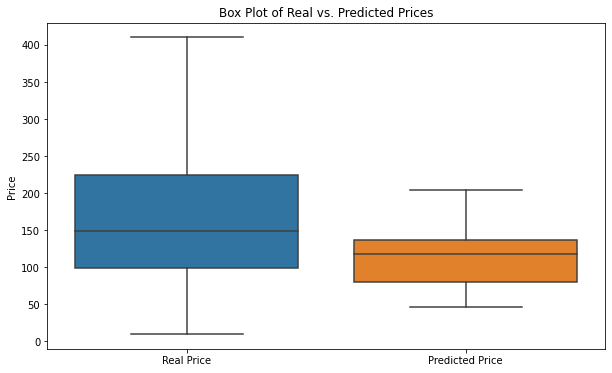

In [129]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_validation[['price', 'price_pred']], showfliers=False)
plt.ylabel('Price')
plt.title('Box Plot of Real vs. Predicted Prices')
plt.xticks([0, 1], ['Real Price', 'Predicted Price'])
plt.show()

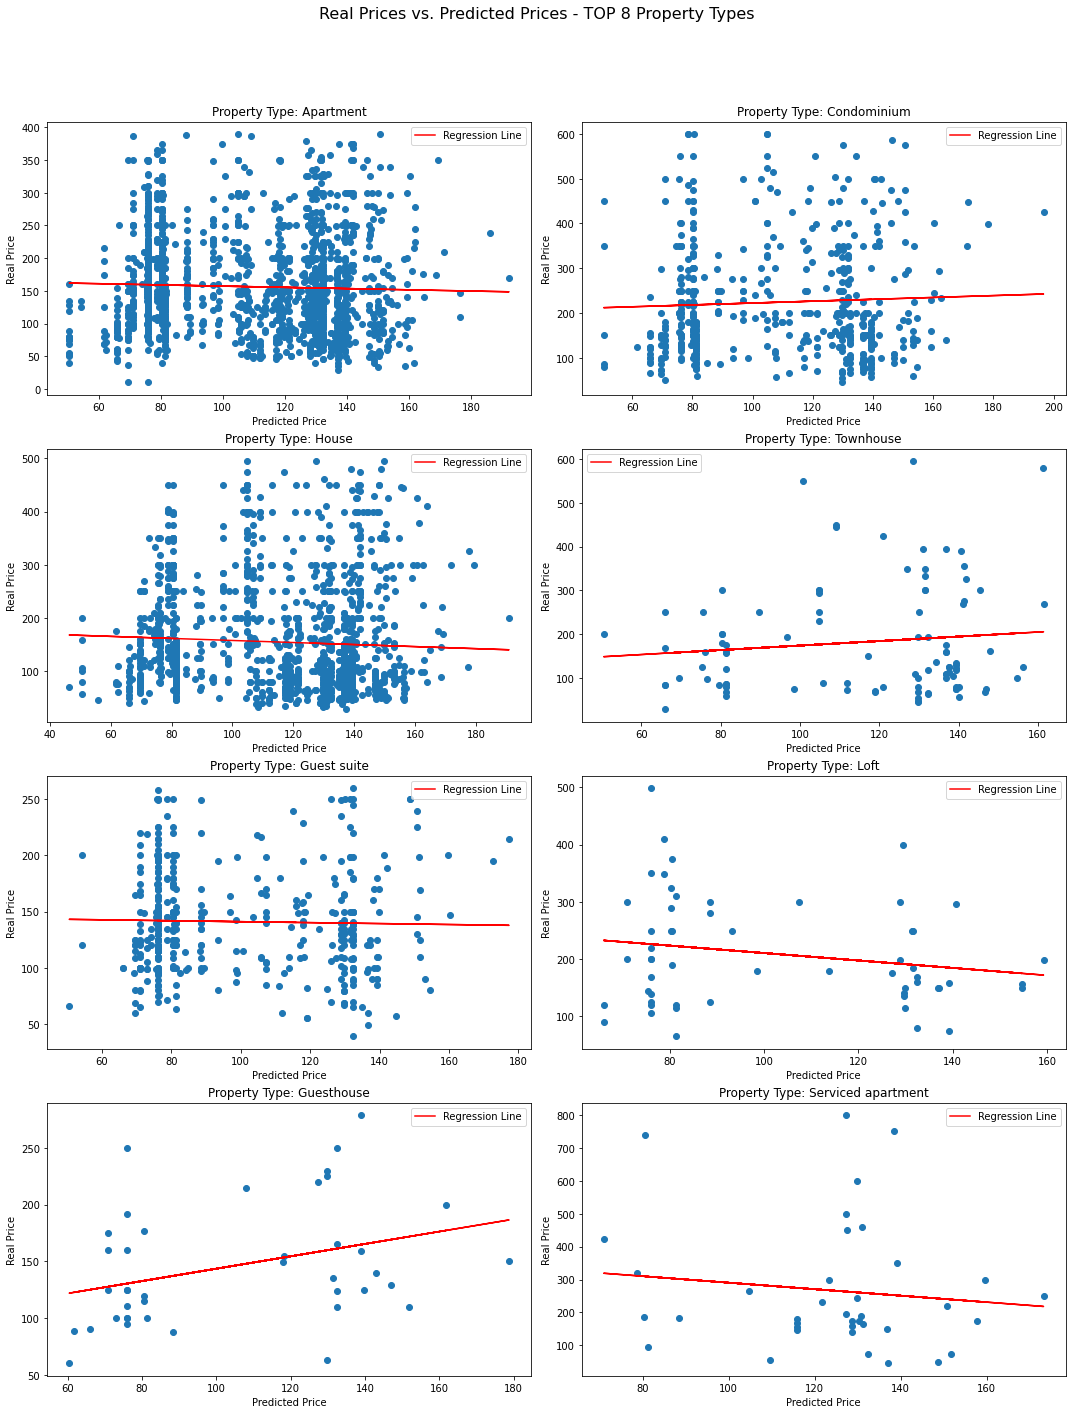

In [130]:
# Filtrar os 8 tipos de propriedade com maior quantidade de dados
top_property_types = df_validation['property_type'].value_counts().nlargest(8).index
df_filtered = df_validation[df_validation['property_type'].isin(top_property_types)]

property_types = df_filtered.property_type.unique()

# Calcular o número de linhas e colunas para a disposição dos subplots
num_rows = int(np.ceil(len(property_types) / 2))
num_cols = 2

# Criar a figura e os subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
fig.suptitle('Real Prices vs. Predicted Prices - TOP 8 Property Types', fontsize=16)

for idx, property_type in enumerate(property_types):
    row = idx // num_cols
    col = idx % num_cols
    
    df_plot = df_filtered[df_filtered.property_type == property_type]
    
    # Remover outliers usando IQR (Interquartile Range)
    Q1 = df_plot['price'].quantile(0.25)
    Q3 = df_plot['price'].quantile(0.75)
    IQR = Q3 - Q1
    df_plot = df_plot[(df_plot['price'] >= Q1 - 1.5 * IQR) & (df_plot['price'] <= Q3 + 1.5 * IQR)]
    
    # Ajustar o modelo de regressão linear
    coeffs = np.polyfit(df_plot['price_pred'], df_plot['price'], 1)
    intercept = coeffs[1]
    slope = coeffs[0]
    
    ax = axes[row, col]
    
    # Scatter plot
    ax.scatter(df_plot['price_pred'], df_plot['price'])
    
    # Linha de regressão
    ax.plot(df_plot['price_pred'], slope * df_plot['price_pred'] + intercept, color='red', label='Regression Line')
    
    ax.set_xlabel('Predicted Price')
    ax.set_ylabel('Real Price')
    ax.set_title(f'Property Type: {property_type}')
    ax.legend()

# Ajustar o layout e mostrar a figura
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


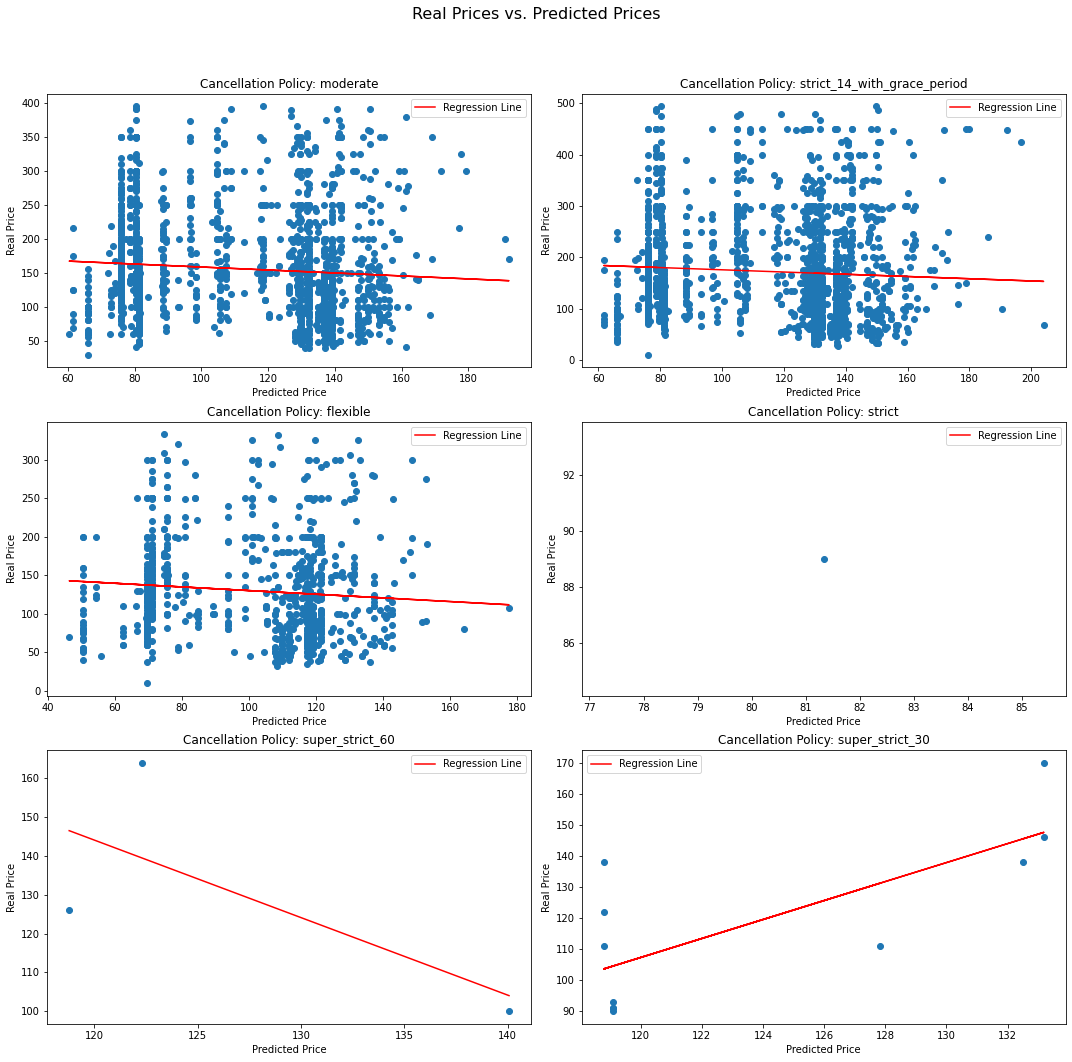

In [131]:
# Filtrar as 8 políticas de cancelamento mais relevantes
top_cancelation_policies = df_validation['cancellation_policy'].value_counts().nlargest(8).index
df_filtered = df_validation[df_validation['cancellation_policy'].isin(top_cancelation_policies)]

cancelation_policies = df_filtered.cancellation_policy.unique()

# Calcular o número de linhas e colunas para a disposição dos subplots
num_rows = int(np.ceil(len(cancelation_policies) / 2))
num_cols = 2

# Criar a figura e os subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
fig.suptitle('Real Prices vs. Predicted Prices', fontsize=16)

for idx, cancellation_policy in enumerate(cancelation_policies):
    row = idx // num_cols
    col = idx % num_cols
    
    df_plot = df_filtered[df_filtered.cancellation_policy == cancellation_policy]
    
    # Remover outliers usando IQR (Interquartile Range)
    Q1 = df_plot['price'].quantile(0.25)
    Q3 = df_plot['price'].quantile(0.75)
    IQR = Q3 - Q1
    df_plot = df_plot[(df_plot['price'] >= Q1 - 1.5 * IQR) & (df_plot['price'] <= Q3 + 1.5 * IQR)]
    
    # Ajustar o modelo de regressão linear
    coeffs = np.polyfit(df_plot['price_pred'], df_plot['price'], 1)
    intercept = coeffs[1]
    slope = coeffs[0]
    
    ax = axes[row, col]
    
    # Scatter plot
    ax.scatter(df_plot['price_pred'], df_plot['price'])
    
    # Linha de regressão
    ax.plot(df_plot['price_pred'], slope * df_plot['price_pred'] + intercept, color='red', label='Regression Line')
    
    ax.set_xlabel('Predicted Price')
    ax.set_ylabel('Real Price')
    ax.set_title(f'Cancellation Policy: {cancellation_policy}')
    ax.legend()

# Ajustar o layout e mostrar a figura
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


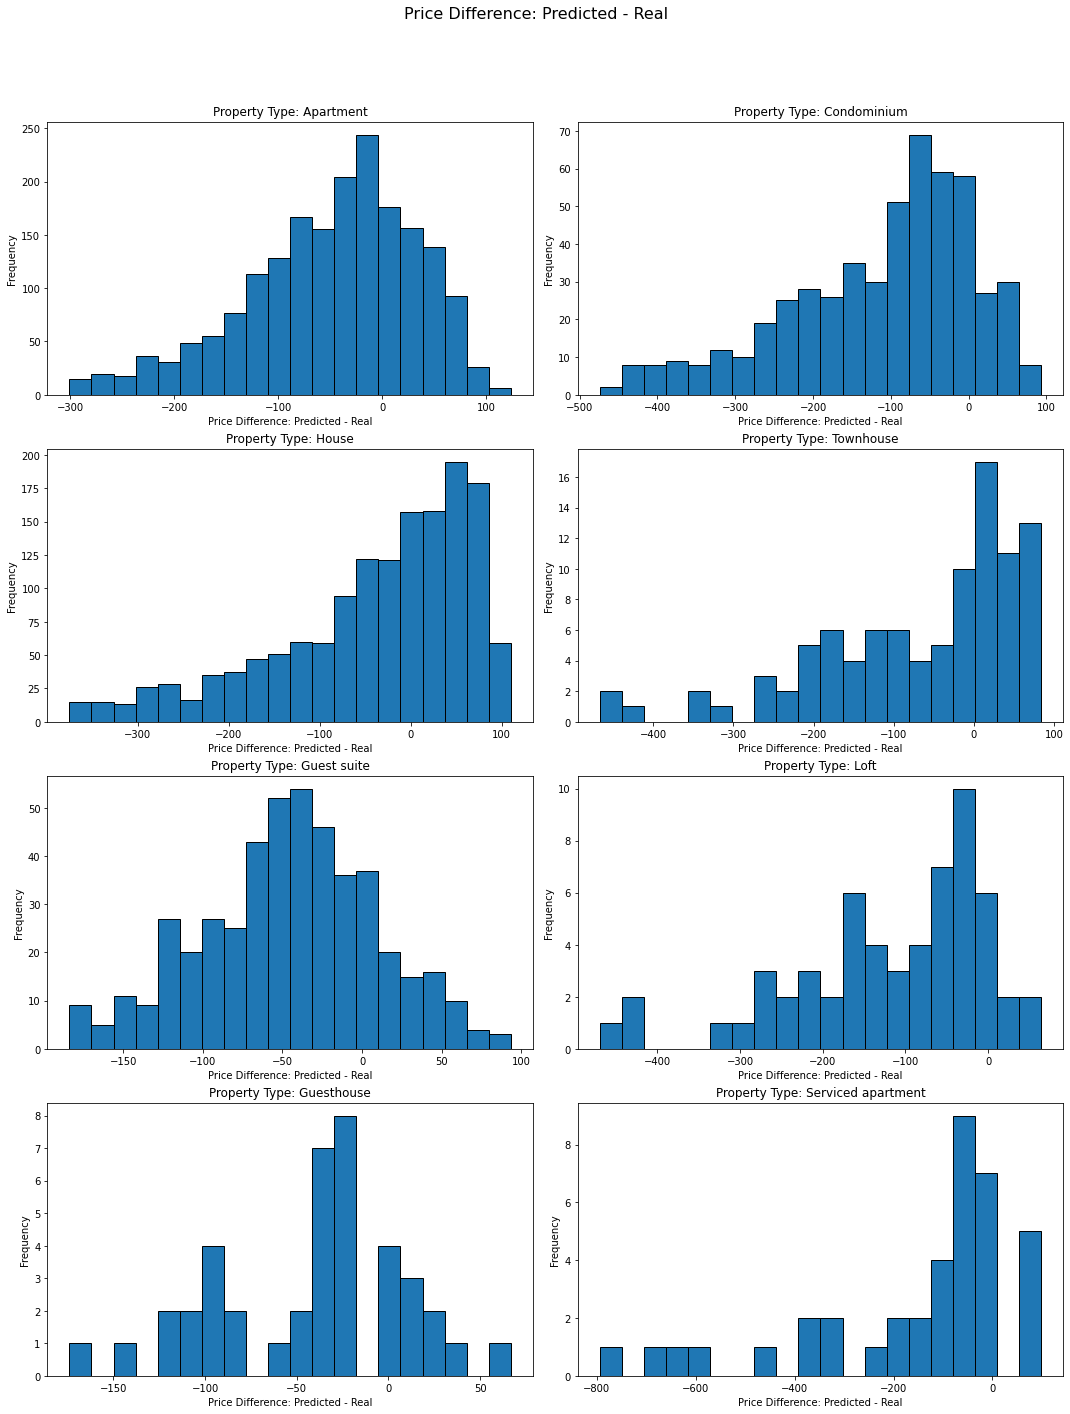

In [132]:
# Calculando a diferença entre o valor predito e o valor real
df_validation['price_difference'] = df_validation['price_pred'] - df_validation['price']

# Filtrar os 8 tipos de propriedade mais relevantes
top_property_types = df_validation['property_type'].value_counts().nlargest(8).index
df_filtered = df_validation[df_validation['property_type'].isin(top_property_types)]

property_types = df_filtered.property_type.unique()

# Calcular o número de linhas e colunas para a disposição dos subplots
num_rows = int(np.ceil(len(property_types) / 2))
num_cols = 2

# Criar a figura e os subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
fig.suptitle('Price Difference: Predicted - Real', fontsize=16)

for idx, property_type in enumerate(property_types):
    row = idx // num_cols
    col = idx % num_cols
    
    df_plot = df_filtered[df_filtered.property_type == property_type]
    
    # Remover outliers usando IQR (Interquartile Range)
    Q1 = df_plot['price_difference'].quantile(0.25)
    Q3 = df_plot['price_difference'].quantile(0.75)
    IQR = Q3 - Q1
    df_plot = df_plot[(df_plot['price_difference'] >= Q1 - 1.5 * IQR) & (df_plot['price_difference'] <= Q3 + 1.5 * IQR)]
    
    ax = axes[row, col]
    
    # Histograma da diferença entre o valor predito e o valor real
    ax.hist(df_plot['price_difference'], bins=20, edgecolor='black')
    
    ax.set_xlabel('Price Difference: Predicted - Real')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Property Type: {property_type}')

# Ajustar o layout e mostrar a figura
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


#### Discussão dos resultados
Embora essa solução apresente uma perda no faturamento por aluguel na maioria dos tipos de propriedade, encontramos casos onde o valor cobrado poderia ate mesmo ser maior do que o atual. Entretanto, o grande objetivo não era ajustar os valores para aumentar lucro por aluguel individual mas sim encontrar um cenário de precificação ideal para fomentar o número de agendamentos e assim a rentabilidade dos imóveis

## Proposta para produtização do modelo (EXEMPLO)
Abaixo temos um código de como poderia ser feita a produtização desse modelo usando o MLFlow, como não tenho acesso a instâncias em nuvem para rodar esse pipeline o código é apenas um exemplo

In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Carregar os dados e fazer o pré-processamento
# (substituir por suas etapas de preparação de dados)

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar o modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer predições no conjunto de teste
y_pred = model.predict(X_test)

# Calcular métricas
mse = mean_squared_error(y_test, y_pred)

# Log das métricas no MLflow
with mlflow.start_run() as run:
    mlflow.log_param("n_estimators", 100)
    mlflow.log_metric("mse", mse)
    mlflow.sklearn.log_model(model, "random_forest_model")

# Fim do treinamento e log das métricas

# Implantação do modelo
model_uri = f"runs:/{run.info.run_id}/random_forest_model"
loaded_model = mlflow.sklearn.load_model(model_uri)

# Fazer previsões com o modelo carregado
predictions = loaded_model.predict(new_data)

# Finalização da implantação e previsões


### Explicação do Pipeline
#### Pipeline de MLOps com MLflow: Treinamento, Implantação e Monitoramento de Modelos

Nesta seção, detalharemos o passo a passo da implementação de um pipeline de MLOps utilizando a biblioteca MLflow. Esse pipeline abrange o treinamento de um modelo de regressão, log das métricas e modelo no MLflow, implantação do modelo treinado e previsões em novos dados.

##### Passo 1: Preparação dos Dados

Primeiro, carregamos os dados relevantes e realizamos qualquer pré-processamento necessário, como limpeza de dados, transformações e engenharia de recursos. Neste exemplo, omitimos essas etapas para simplificação.

##### Passo 2: Divisão dos Dados

Dividimos os dados em conjuntos de treinamento e teste usando a função `train_test_split` da biblioteca `sklearn`.

##### Passo 3: Treinamento do Modelo

Criamos um modelo de regressão de floresta aleatória (`RandomForestRegressor`) e o treinamos com os dados de treinamento.

##### Passo 4: Avaliação do Modelo

Fazemos previsões no conjunto de teste e calculamos a métrica de erro médio quadrático (MSE) para avaliar o desempenho do modelo.

##### Passo 5: Log das Métricas e Modelo no MLflow

Usamos o MLflow para registrar parâmetros, métricas e o modelo treinado. Iniciamos um novo "run" com `mlflow.start_run()`, registramos os parâmetros do modelo e as métricas usando `mlflow.log_param()` e `mlflow.log_metric()`, e finalmente, usamos `mlflow.sklearn.log_model()` para logar o modelo.

##### Passo 6: Implantação do Modelo

Após o treinamento e registro do modelo no MLflow, podemos implantar o modelo treinado usando seu URI. Carregamos o modelo com `mlflow.sklearn.load_model()`.

##### Passo 7: Fazer Previsões

Usamos o modelo carregado para fazer previsões em novos dados.

---
**Nota**: Este é um exemplo simplificado e didático para demonstrar o fluxo básico de um pipeline de MLOps usando MLflow. A implementação completa pode envolver mais etapas, como monitoramento, automação de implantação e gerenciamento de configurações.